In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

from data_loading import get_jester_data
from evaluation import evaluate_policy
from policies.dlintsrp import D_LinTS_RP
from policies.cbrap import CBRAP
from policies.linucb import LinUCB
from policies.linear_ts import LinearTS
from policies.d_lin_ts import DLinTS
from policies.random import RandomPolicy
from policies.egreedy import EGreedy
from reduct_matrix import get_reduct_matrix

from sklearn.model_selection import train_test_split

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
times = 100000

In [6]:
dataset = get_jester_data(times, tune=False)

Dataset creation took 2.4558680057525635 s.


In [7]:
red_dim = 24

### Define policies

In [8]:
total_start_ts = time.time()

#### Introduce nonstationarity

In [9]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

In [10]:
intervals = list(zip(CHANGE_POINTS, CHANGE_POINTS[1:]))
intervals

[(1, 5000),
 (5000, 10000),
 (10000, 20000),
 (20000, 35000),
 (35000, 50000),
 (50000, 65000),
 (65000, 80000),
 (80000, 90000),
 (90000, 100000)]

In [11]:
SHIFT_SIZE = 0.33

In [12]:


def evaluation_nonstationarity_function(trial, arm, num_of_arms):
    """Takes trial and arm index as input and returns index of arm with which to swap."""
    N_ARMS = num_of_arms
    shift_size_int = int(SHIFT_SIZE * N_ARMS)

    # intervals = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000]
    intervals = CHANGE_POINTS
    for i, (start, end) in enumerate(zip(intervals, intervals[1:])):
        if start <= trial < end:
            return (arm + i * shift_size_int) % N_ARMS
    return arm



#### Check nonstationarity

In [13]:
reward_vecs = np.zeros((times, 140))
users = dataset.generate_users(times, tune=False)

for i, user_data in enumerate(users):
    context, reward_vector, score_true, missing_vector = user_data
    reward_vecs[i, :] = reward_vector

In [14]:
nonst_reward_vecs = np.zeros(reward_vecs.shape)
for t in range(reward_vecs.shape[0]):
    for a in range(reward_vecs.shape[1]):
        nonst_reward_vecs[t, a] = reward_vecs[t, evaluation_nonstationarity_function(t, a, 140)]

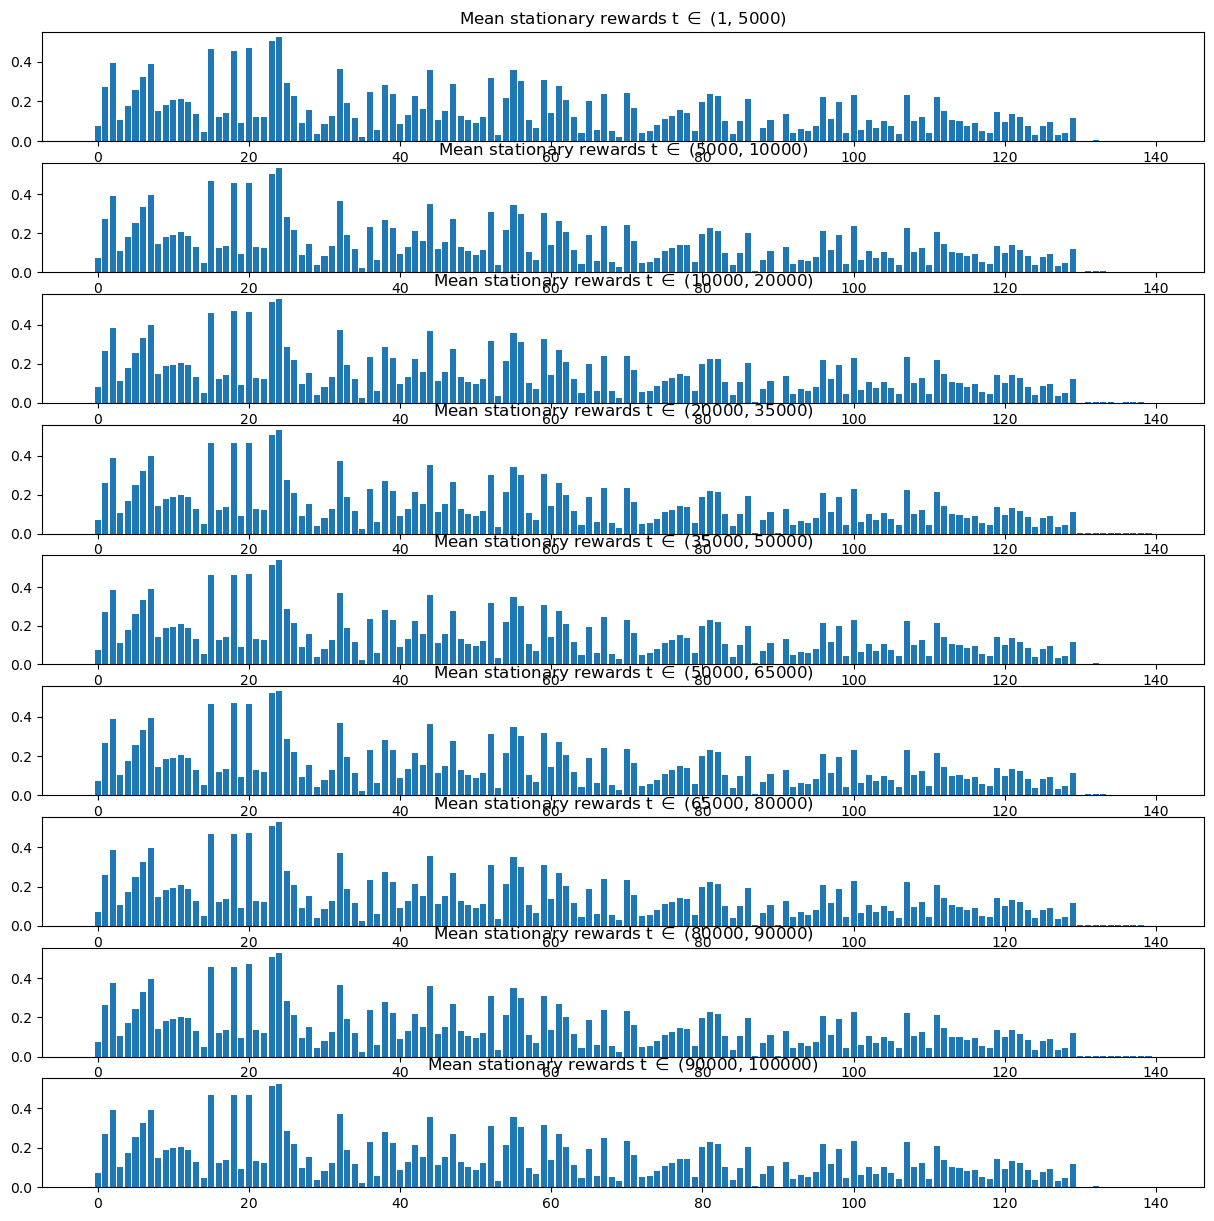

In [15]:
fig, axs = plt.subplots(len(intervals) ,1, figsize=(15, 15))

for i, intrvl in enumerate(intervals):
    intrvl_mean_rews = reward_vecs[intrvl[0]:intrvl[1]].mean(axis=0)
    axs[i].bar(list(range(len(dataset.actions))), intrvl_mean_rews)
    axs[i].set_title(fr"Mean stationary rewards t $\in$ {intrvl}")

plt.show()

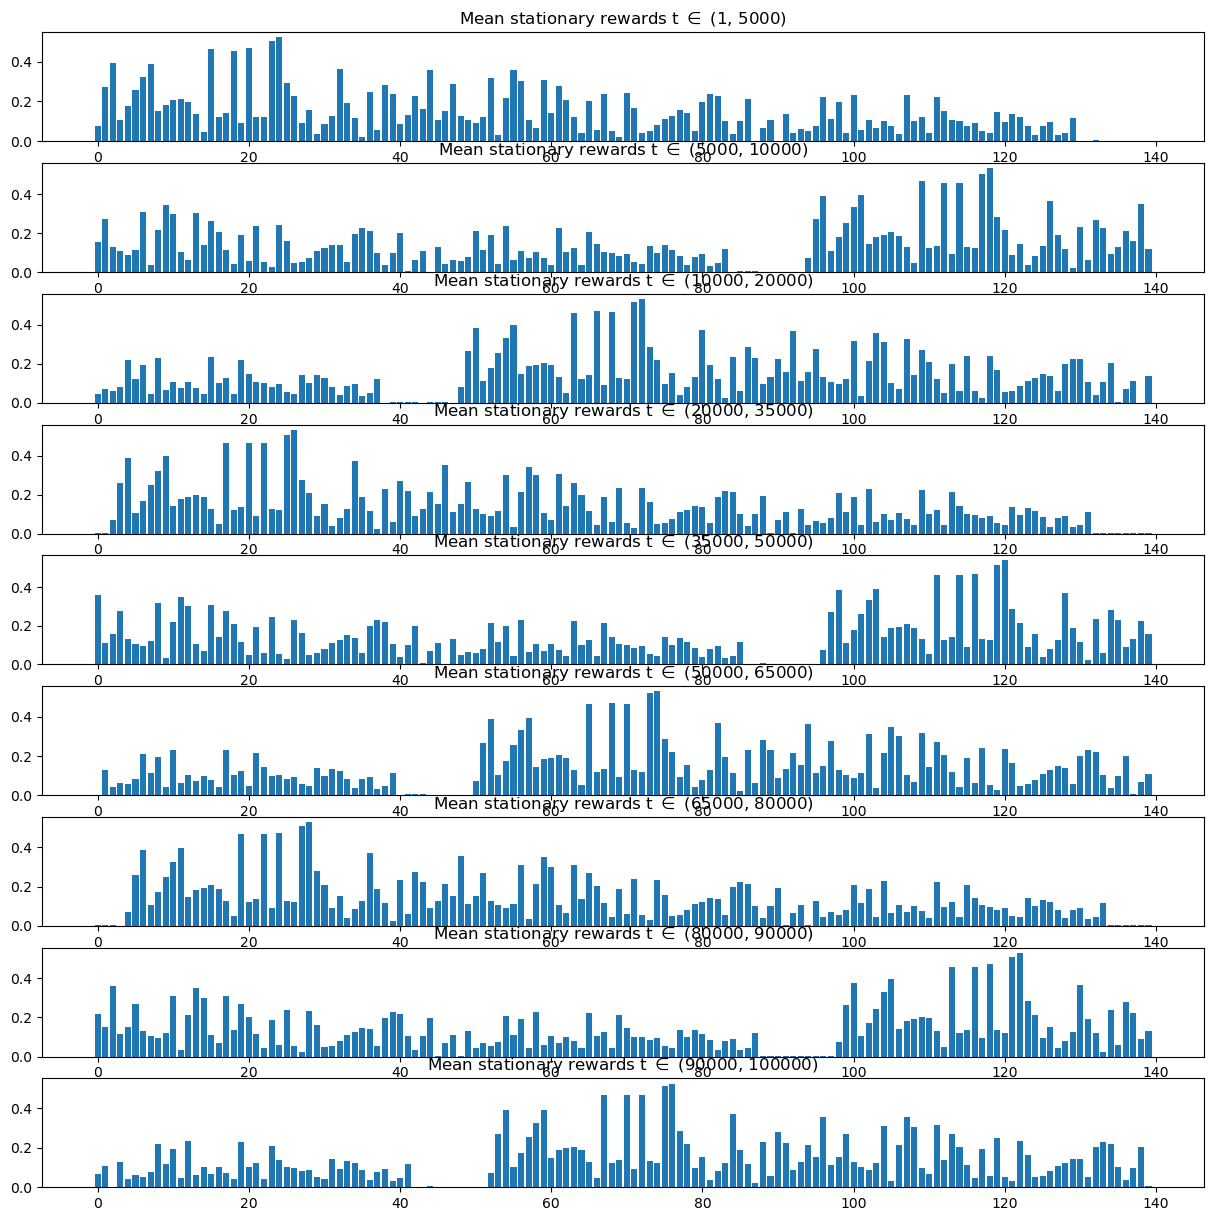

In [16]:
fig, axs = plt.subplots(len(intervals) ,1, figsize=(15, 15))

for i, intrvl in enumerate(intervals):
    intrvl_mean_rews = nonst_reward_vecs[intrvl[0]:intrvl[1]].mean(axis=0)
    axs[i].bar(list(range(len(dataset.actions))), intrvl_mean_rews)
    axs[i].set_title(fr"Mean stationary rewards t $\in$ {intrvl}")

plt.show()


In [17]:
del nonst_reward_vecs

### Run evaluation

#### Define policies

In [21]:
ctx_dim = 300


policies = {
    # Tuned
#     'LinearTS': LinearTS(context_dimension=ctx_dim, nu=0.3, seed=seed),
    'LinUCB': LinUCB(context_dimension=ctx_dim, alpha=0.8),
#     'EGreedy': EGreedy(epsilon=0.001),
# #     'DLinTS': DLinTS(context_dimension=ctx_dim, gamma=0.99, a=0.1,  seed=seed),
#     'CBRAP d=15': CBRAP(context_dimension=ctx_dim, red_dim=15, alpha=0.6),
#     'CBRAP d=30': CBRAP(context_dimension=ctx_dim, red_dim=30, alpha=0.6),
#     'CBRAP d=60': CBRAP(context_dimension=ctx_dim, red_dim=60, alpha=0.6),
#     'CBRAP d=150': CBRAP(context_dimension=ctx_dim, red_dim=150, alpha=0.6),
#     'CBRAP d=300': CBRAP(context_dimension=ctx_dim, red_dim=300, alpha=0.6),
#     'D-LinTS-RP d=15': D_LinTS_RP(context_dimension=ctx_dim, red_dim=15, gamma=0.9, a=0.1, seed=seed),
#     'D-LinTS-RP d=30': D_LinTS_RP(context_dimension=ctx_dim, red_dim=30, gamma=0.99, a=0.2, seed=seed),
#     'D-LinTS-RP d=60': D_LinTS_RP(context_dimension=ctx_dim, red_dim=60, gamma=0.99, a=0.2, seed=seed),
#     'D-LinTS-RP d=150': D_LinTS_RP(context_dimension=ctx_dim, red_dim=150, gamma=0.999, a=0.2, seed=seed),
    'D-LinTS-RP d=300': D_LinTS_RP(context_dimension=ctx_dim, red_dim=300, gamma=0.99, a=0.1, seed=seed),
#     'Random': RandomPolicy(),
}

In [22]:
results = {'reward': {}, 'ndcg': {}}
for p_name, policy in policies.items():
    start_ts = time.time()

    reward, ndcg = evaluate_policy(
        policy, times, dataset, nonstationarity_function=evaluation_nonstationarity_function
    )
    results['reward'][p_name] = reward
    results['ndcg'][p_name] = ndcg
    print(f"Total reward of {p_name} is {reward[-1][0]}")
    print(f"Total time of {p_name} is {datetime.timedelta(seconds=time.time() - start_ts)}")

Using evaluation dataset
0
5000
Total reward of LinUCB is 4364.0
Total time of LinUCB is 0:01:52.206875
Using evaluation dataset
0
5000
Total reward of D-LinTS-RP d=300 is 4544.0
Total time of D-LinTS-RP d=300 is 1:17:18.710112


In [23]:
with open("jester_results.pkl", "wb") as f:
    pickle.dump(results, f)

### Plot results

In [24]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
            max_vline=max(max_vline, max(ctr))
        else:
            to_plot = rewards

            max_vline=max(max_vline, max(rewards))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.65
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend();
    plt.show();

In [25]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on Jester')

    plt.legend();
    plt.show();

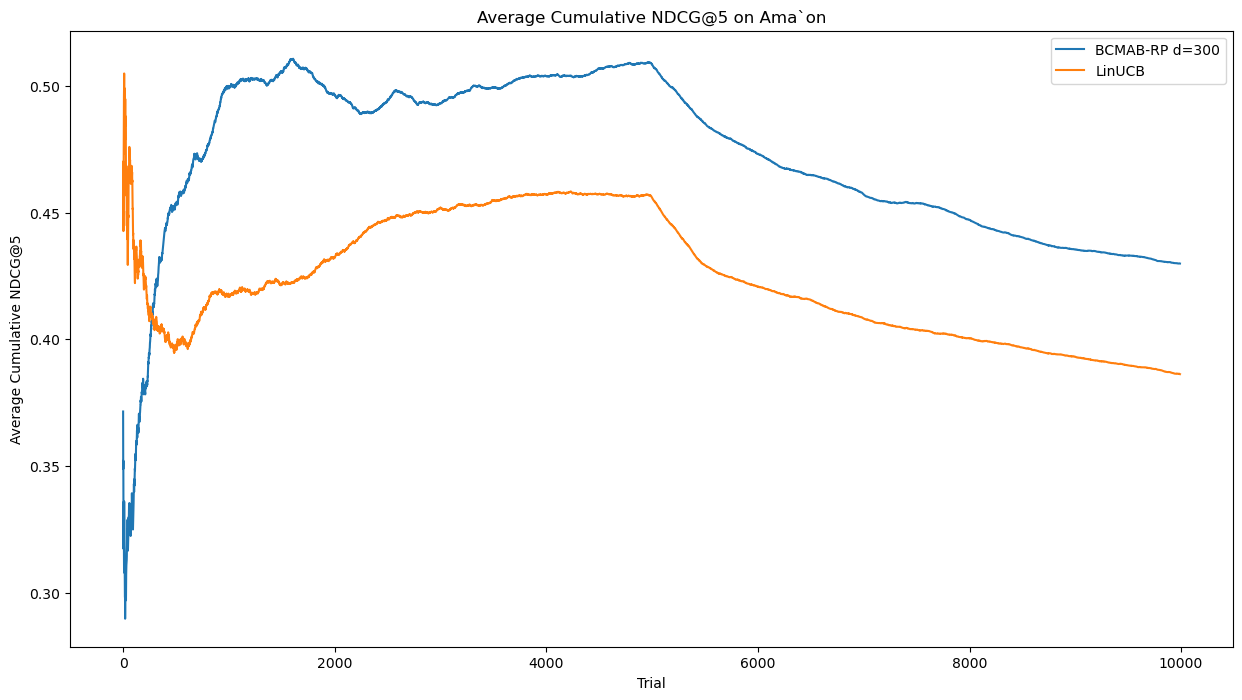

In [26]:
plot_ndcg(results['ndcg'])

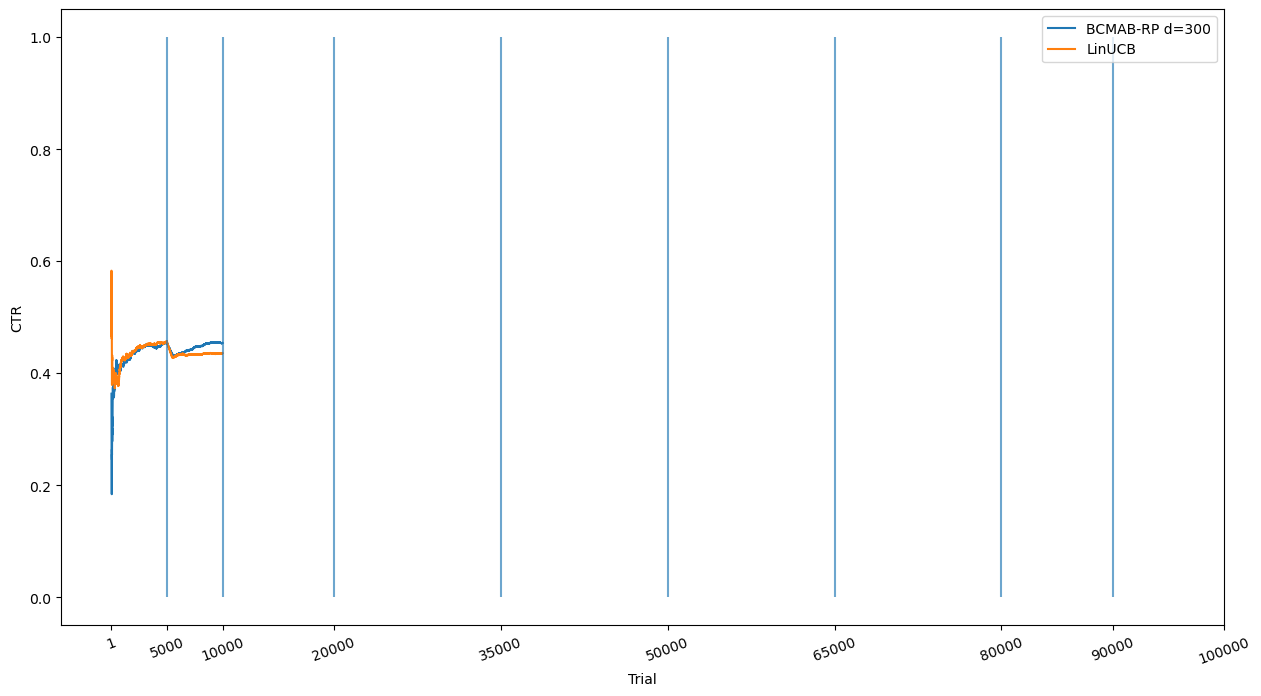

In [27]:
plot_ctrs_or_rewards(results['reward'], 'CTR', CHANGE_POINTS)

In [28]:
print(f"Total time is {datetime.timedelta(seconds=time.time() - total_start_ts)}")

Total time is 1:21:54.559392


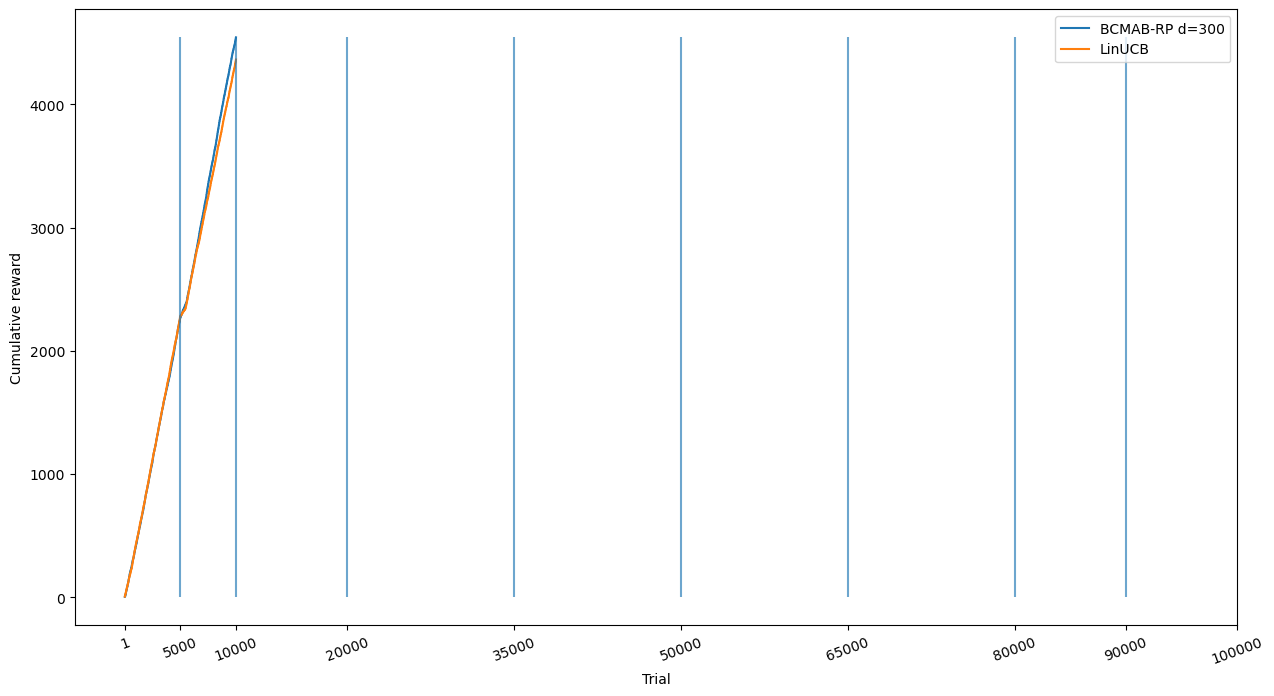

In [29]:
plot_ctrs_or_rewards(results['reward'], 'Cumulative reward', CHANGE_POINTS)

In [30]:
results['reward']['LinUCB'][-1]

array([4364.])

In [31]:
results['reward']['LinearTS'][-1]

KeyError: 'LinearTS'

In [ ]:
def plot_ctrs_or_rewards_new(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
        
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
        7: ('x', 'cyan'),
        8: ('>', 'forestgreen'),
        9: ('d', 'darkmagenta'),
        10: ('<', 'darkgoldenrod'),
    }
    
    N = 10
    
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
            max_vline=max(max_vline, max(ctr))
        else:
            to_plot = rewards

            max_vline=max(max_vline, max(rewards))
            
        mark, color = ind_to_params[ind]
        ax.plot(to_plot[N:], label=label, linestyle=':',
            marker=mark, markevery=7500, markersize=11, markeredgewidth=2.5,
            fillstyle='none', color=color,
            linewidth=4.0,
        )
        

    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.65
    )    
    
            
    extraticks = change_points
    plt.xticks(extraticks, rotation=20, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial', fontsize=38)
    ax.set_ylabel(f'{plot_type}', fontsize=38)
#     ax.set_title(f'{plot_type} on Jester')

    plt.legend(prop={'size': 24}, ncol=1);
    plt.show();